In [1]:
def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return int(sum_x/length), int(sum_y/length)

def show_image_plt(image, json_file):
    point_polygon = np.array(json_file['shapes'][0]['points'], np.int32)
    x,y = centeroidnp(point_polygon)
    hsize = json_file['imageHeight']
    wsize = json_file['imageWidth']
    filename_img = json_file['imagePath']
        
    new_image  = cv2.polylines(image, [point_polygon], True ,(0, 0, 255), 3)
    new_image2 = cv2.circle(new_image, (x, y), 5, (0, 0, 255), 10)
    img_rgb = cv2.cvtColor(new_image2, cv2.COLOR_BGR2RGB)    
    
    plt.title(f'File: {filename_img} \n Centroid: {x,y} \n size {hsize,wsize}')
    plt.imshow(img_rgb)

In [2]:
import os
import cv2
import json

import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import filters
from skimage import morphology
from scipy import ndimage as ndi
import cv2
import numpy as np

In [3]:
img_files_obj_train = []
img_files_obj_train_background = []
img_files_obj_test  = []
json_files_train    = []

df_ref_data = pd.read_csv('../data/ReferenceData/wheres_wally_train.csv', names=['filename_img','centroid_x','centroid_y'])

for root, dirs, files in os.walk('../data/TrainingSet/images'):
    for filee in files:
        img_file_obj = cv2.imread(f'{root}/{filee}', 0)
        img_files_obj_train.append(img_file_obj)  
            
for root, dirs, files in os.walk('../data/TrainingSet/json'):
    for filee in files:
            json_uploaded = open(f'{root}/{filee}','r')
            json_files_train.append(json.loads(json_uploaded.read()))

for root, dirs, files in os.walk('../data/TestSet'):
    for filee in files:
        img_file_obj = cv2.imread(f'{root}/{filee}', 0)
        img_files_obj_test.append(img_file_obj)                

In [4]:
json_files_train_att = []
img_files_obj_train_att = []

for i in range(len(json_files_train)):
    aux = json_files_train[i]['shapes'][0]['points']
    if len(aux) == 4:
        json_files_train_att.append(json_files_train[i])
        img_files_obj_train_att.append(img_files_obj_train[i])
    else:
        print(json_files_train[i]['imagePath'])
img_files_obj_train = img_files_obj_train_att
json_files_train    = json_files_train_att

In [22]:
#== Parameters =======================================================================
BLUR = 10
CANNY_THRESH_1 = 5
CANNY_THRESH_2 = 255
MASK_DILATE_ITER = 10
MASK_ERODE_ITER = 10
MASK_COLOR = (0.0,0.0,0.0) # In BGR format


os.makedirs('../data/train_new',exist_ok = True)
os.makedirs('../data/test_new',exist_ok = True)

def masked(img, path, name_new_image):
    #== Processing =======================================================================

    #-- Read image -----------------------------------------------------------------------
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


    #-- Edge detection -------------------------------------------------------------------
    edges = cv2.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)
    edges = cv2.dilate(edges, None)
    edges = cv2.erode(edges, None)

    #-- Find contours in edges, sort by area ---------------------------------------------
    contour_info = []
    contours, _= cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Previously, for a previous version of cv2, this line was: 
    #  contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Thanks to notes from commenters, I've updated the code but left this note
    for c in contours:
        contour_info.append((
            c,
            cv2.isContourConvex(c),
            cv2.contourArea(c),
        ))
    contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)
    max_contour = contour_info[0]

    #-- Create empty mask, draw filled polygon on it corresponding to largest contour ----
    # Mask is black, polygon is white
    mask = np.zeros(edges.shape)
    cv2.fillConvexPoly(mask, max_contour[0], (255))

    #-- Smooth mask, then blur it --------------------------------------------------------
    mask = cv2.dilate(mask, None, iterations=MASK_DILATE_ITER)
    mask = cv2.erode(mask, None, iterations=MASK_ERODE_ITER)
    mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)
    mask_stack = np.dstack([mask]*3)    # Create 3-channel alpha mask

    #-- Blend masked img into MASK_COLOR background --------------------------------------
    mask_stack  = mask_stack.astype('float32') / 255.0          # Use float matrices, 
    img         = img.astype('float32') / 255.0                 #  for easy blending

    masked = (mask_stack * img) + ((1-mask_stack) * MASK_COLOR) # Blend
    masked = (masked * 255).astype('uint8')                     # Convert back to 8-bit 

    plt.axis('off')
    plt.imshow(masked)                                   # Display
    plt.show()
    cv2.imwrite('../data/'+path+'/'+name_new_image, masked)           # Save

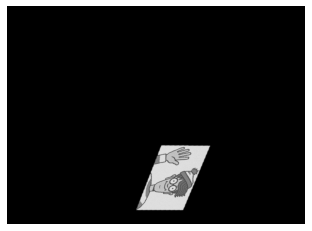

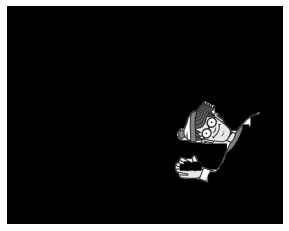

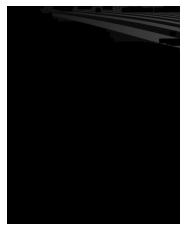

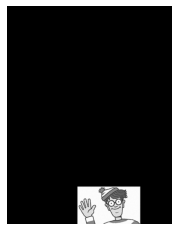

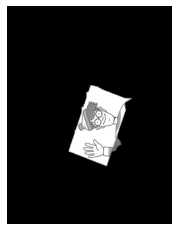

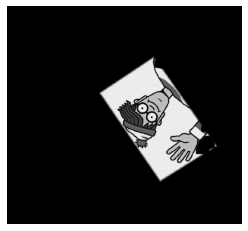

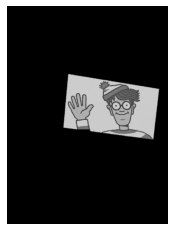

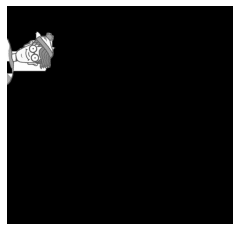

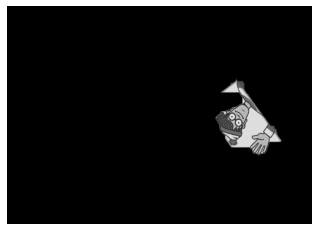

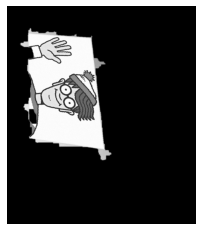

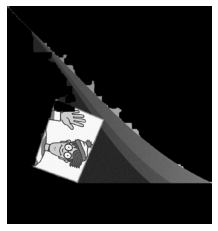

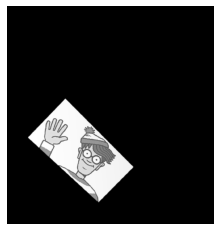

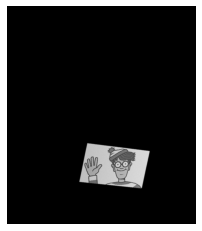

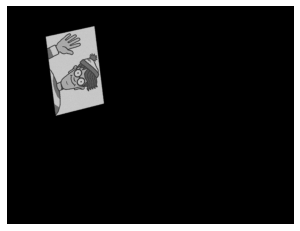

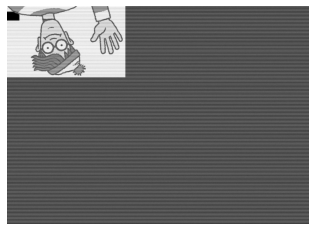

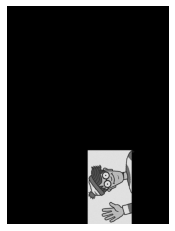

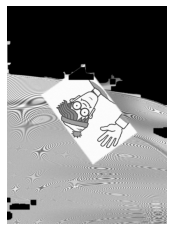

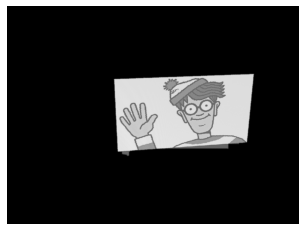

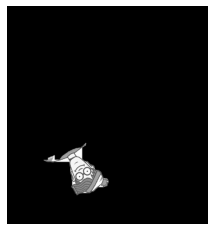

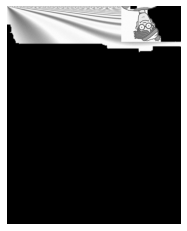

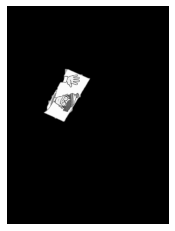

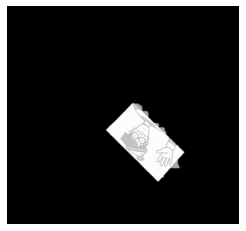

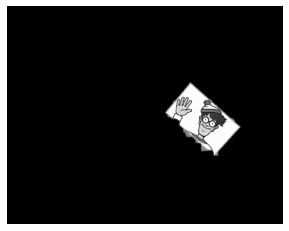

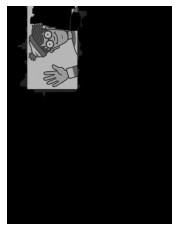

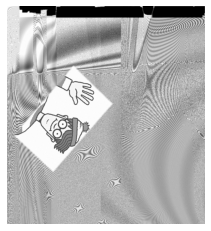

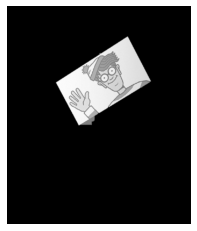

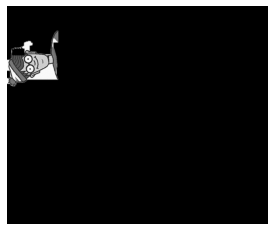

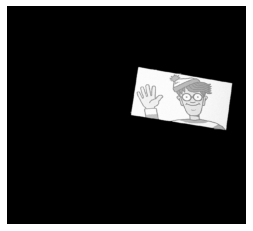

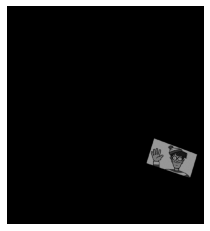

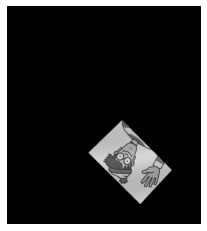

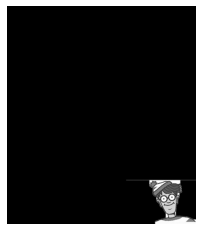

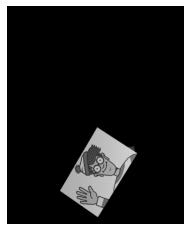

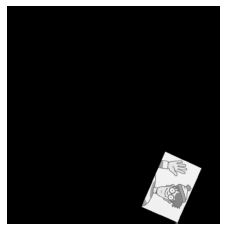

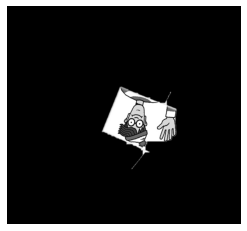

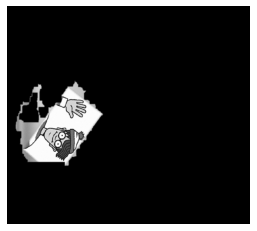

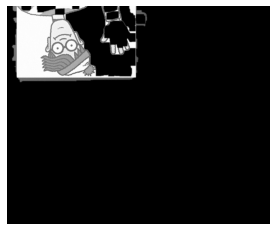

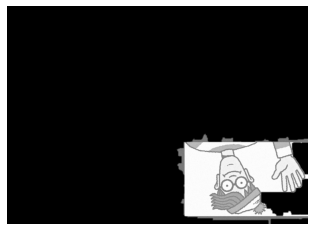

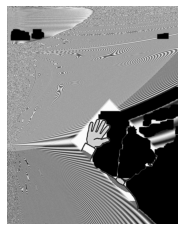

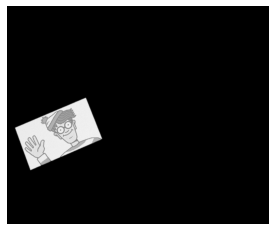

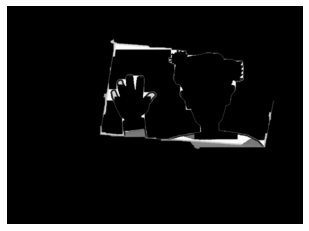

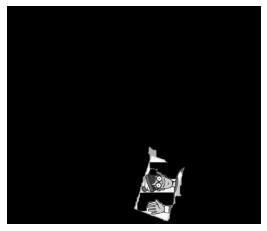

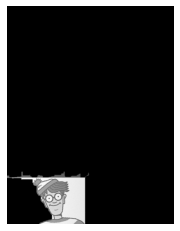

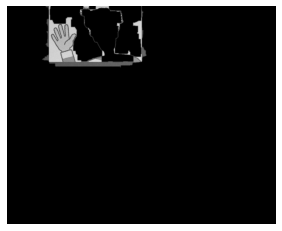

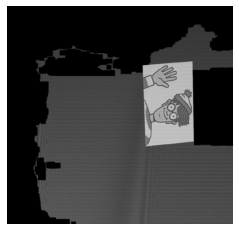

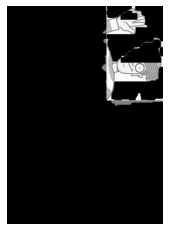

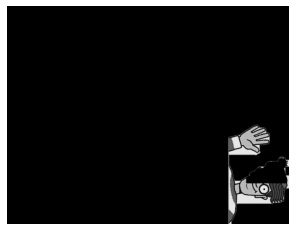

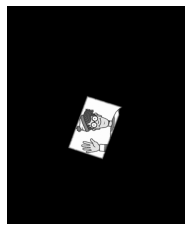

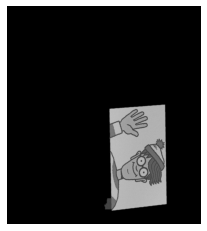

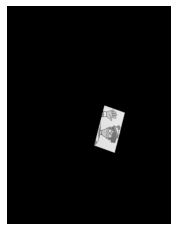

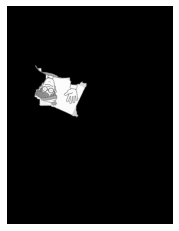

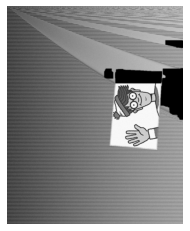

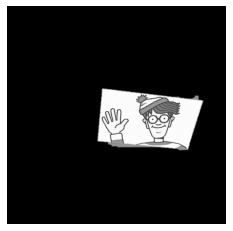

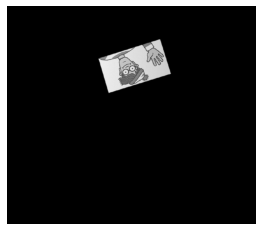

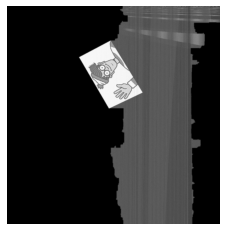

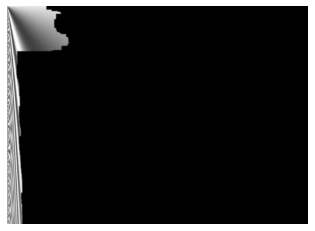

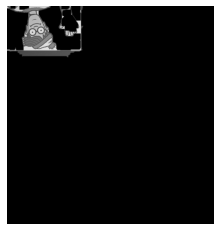

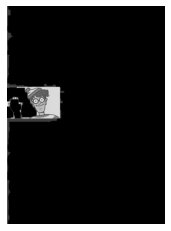

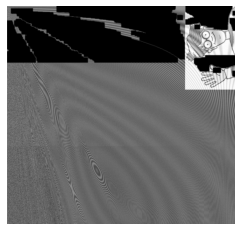

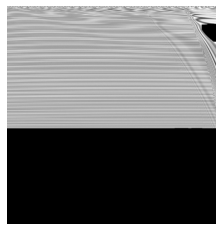

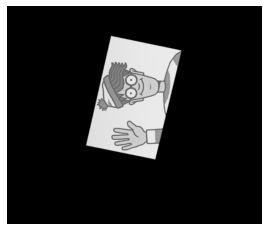

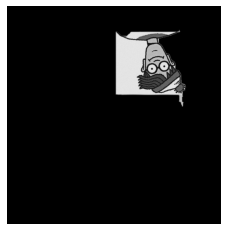

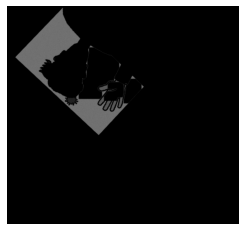

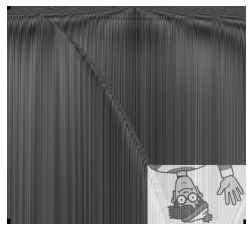

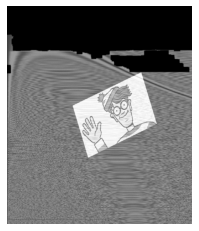

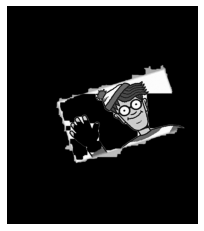

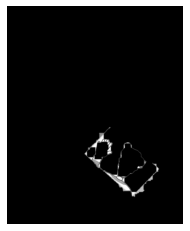

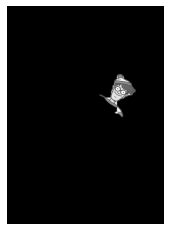

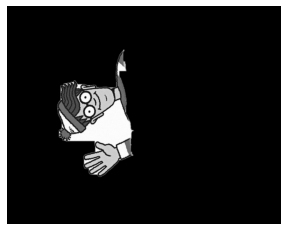

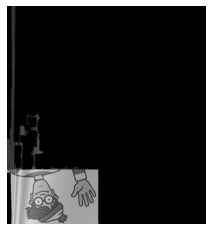

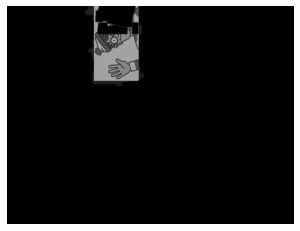

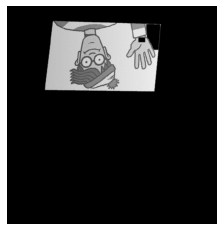

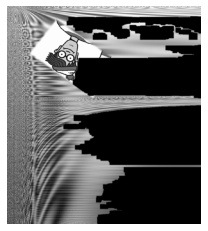

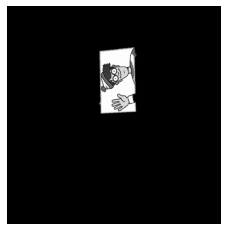

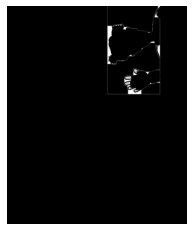

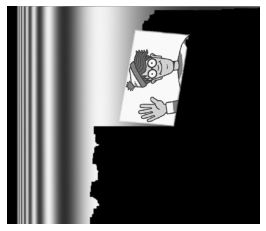

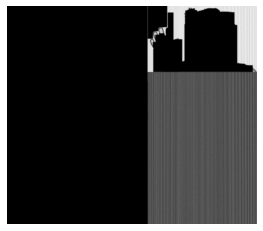

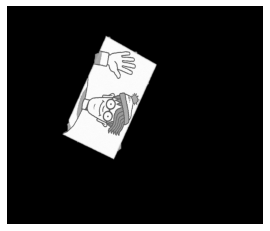

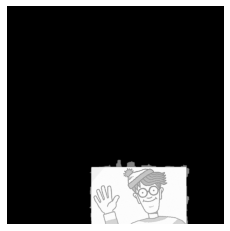

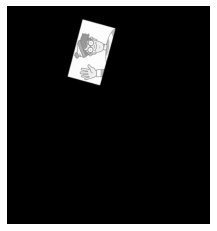

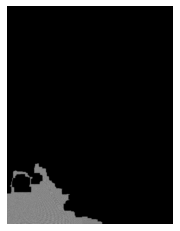

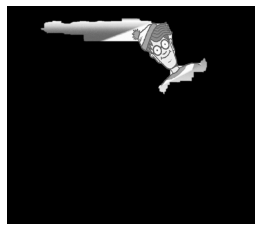

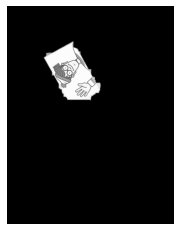

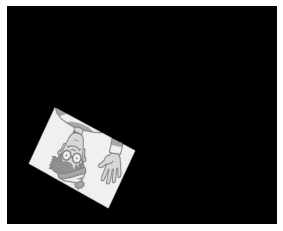

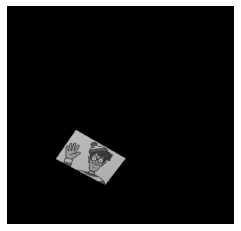

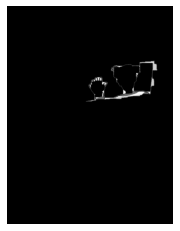

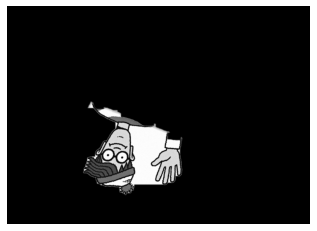

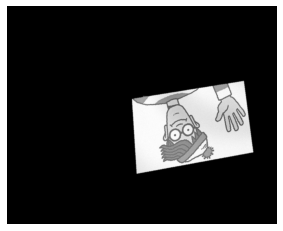

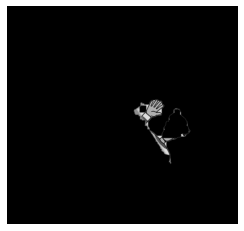

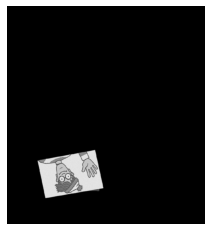

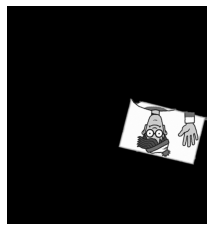

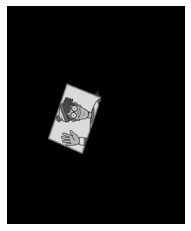

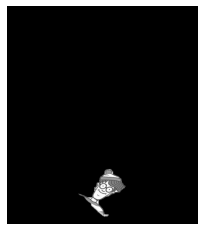

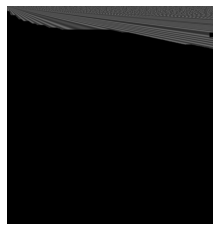

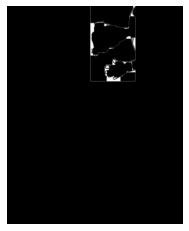

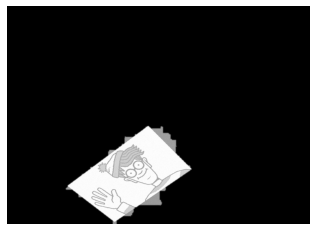

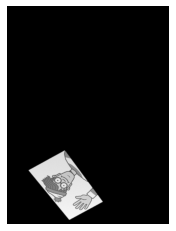

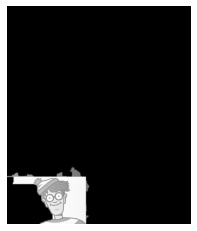

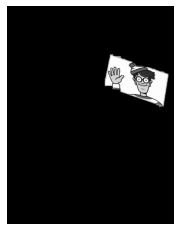

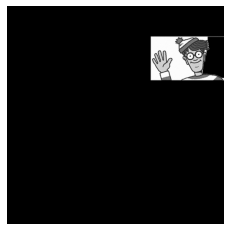

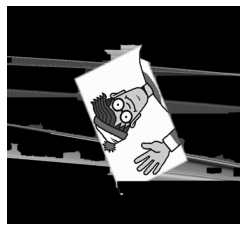

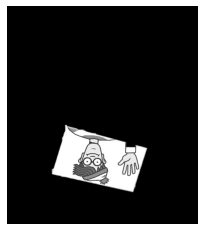

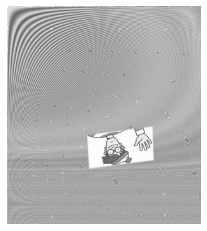

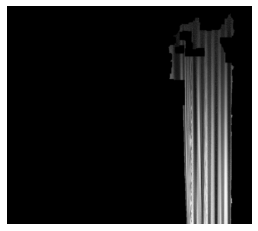

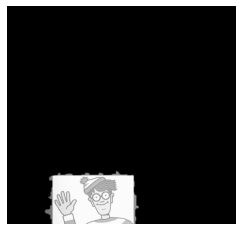

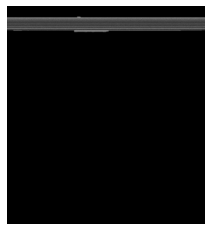

In [23]:
for i in range(len(img_files_obj_train)):
    img = img_files_obj_train[i]
    aux_name_file = json_files_train[i]['imagePath'].split('.')
    name_file = aux_name_file[0]+'_rbackground.jpg'
    masked(img_files_obj_train[i], 'train_new', name_file)

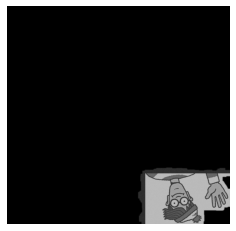

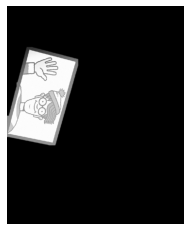

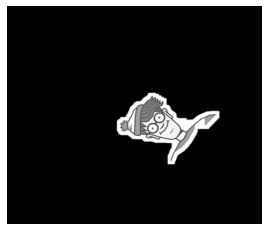

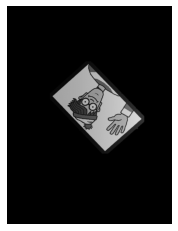

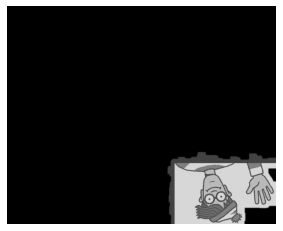

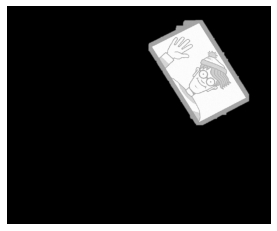

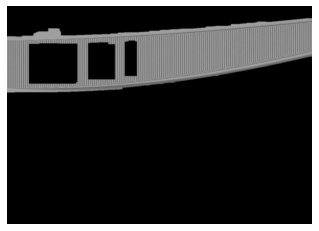

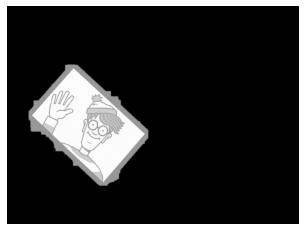

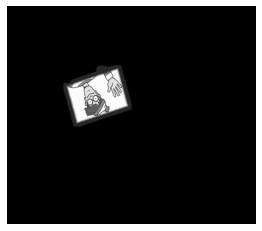

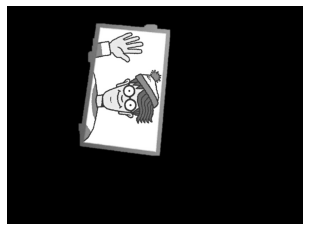

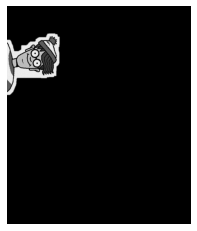

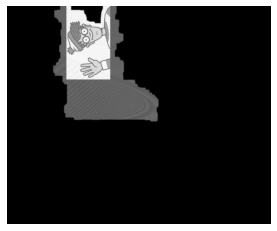

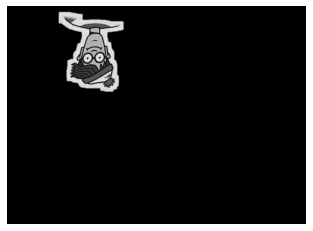

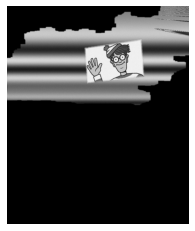

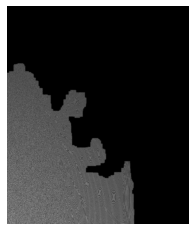

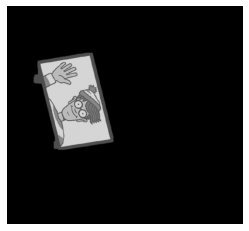

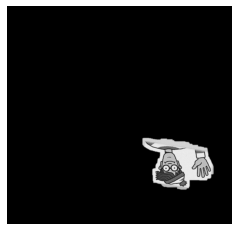

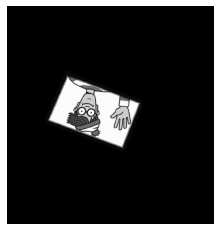

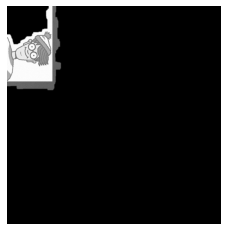

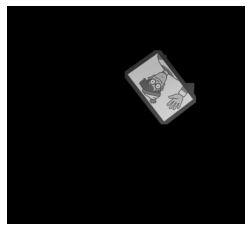

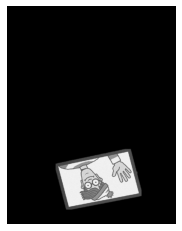

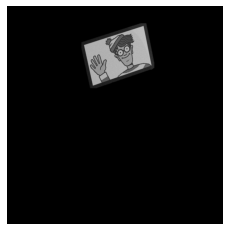

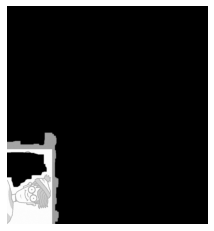

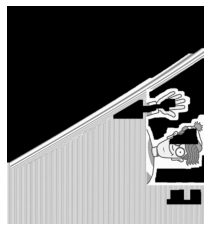

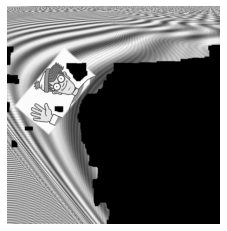

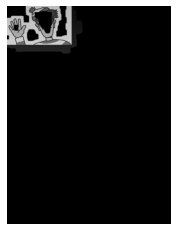

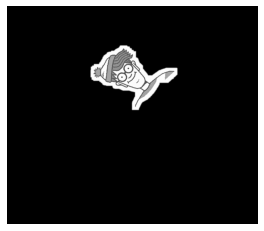

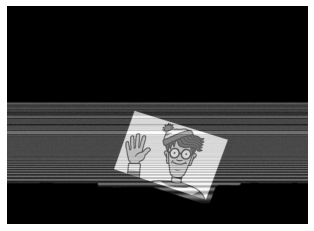

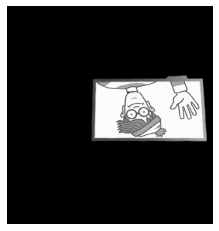

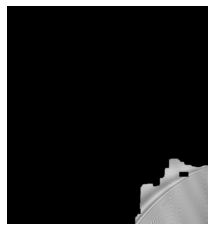

In [11]:
for i in range(len(img_files_obj_test)):
    img = img_files_obj_test[i]
    masked(img_files_obj_test[i], 'test_new', 'wally_masked_'+str(i).zfill(3)+'.jpg')